## Classification with tsfresh and hand generated features

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
import seaborn as sns
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist


from fastdtw import fastdtw

figsize=(17,9)

import logging

## TSFRESH approach

## Load and visualize data
The dataset consists of timeseries for 7352 accelerometer readings. Each reading represents an accelerometer reading for 2.56 sec at 50hz (for a total of 128 samples per reading). Furthermore, each reading corresponds one of six activities (walking, walking upstairs, walking downstairs, sitting, standing and laying)

For more information, or to fetch dataset, go to https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [2]:
# fetch dataset from uci
download_har_dataset()

In [3]:
df = load_har_dataset()
df.head()
df.shape

(7352, 128)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328


/Users/Vlad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


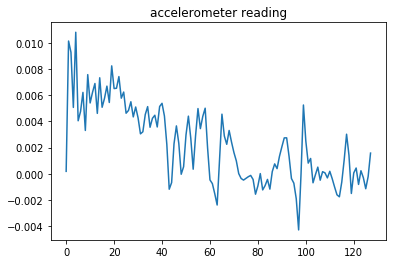

In [38]:
plt.title('accelerometer reading')
plt.plot(df.ix[0,:])
plt.show()

In [39]:

df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328


## Extract Features

In [40]:
extraction_settings = ComprehensiveFCParameters()

In [41]:
# rearrange first 500 sensor readings column-wise, not row-wise

N = 500
master_df = pd.DataFrame({0: df[:N].values.flatten(),
                          1: np.arange(N).repeat(df.shape[1])})
master_df.head()

,0,1
0,0.000181,0
1,0.010139,0
2,0.009276,0
3,0.005066,0
4,0.010810,0


In [42]:
%time X = extract_features(master_df, column_id=1, impute_function=impute, default_fc_parameters=extraction_settings);

Feature Extraction: 100%|██████████| 10/10 [01:00<00:00,  6.05s/it]
 '0__fft_coefficient__coeff_65__attr_"angle"'
 '0__fft_coefficient__coeff_65__attr_"imag"'
 '0__fft_coefficient__coeff_65__attr_"real"'
 '0__fft_coefficient__coeff_66__attr_"abs"'
 '0__fft_coefficient__coeff_66__attr_"angle"'
 '0__fft_coefficient__coeff_66__attr_"imag"'
 '0__fft_coefficient__coeff_66__attr_"real"'
 '0__fft_coefficient__coeff_67__attr_"abs"'
 '0__fft_coefficient__coeff_67__attr_"angle"'
 '0__fft_coefficient__coeff_67__attr_"imag"'
 '0__fft_coefficient__coeff_67__attr_"real"'
 '0__fft_coefficient__coeff_68__attr_"abs"'
 '0__fft_coefficient__coeff_68__attr_"angle"'
 '0__fft_coefficient__coeff_68__attr_"imag"'
 '0__fft_coefficient__coeff_68__attr_"real"'
 '0__fft_coefficient__coeff_69__attr_"abs"'
 '0__fft_coefficient__coeff_69__attr_"angle"'
 '0__fft_coefficient__coeff_69__attr_"imag"'
 '0__fft_coefficient__coeff_69__attr_"real"'
 '0__fft_coefficient__coeff_70__attr_"abs"'
 '0__fft_coefficient__coeff_70__

CPU times: user 2.2 s, sys: 447 ms, total: 2.65 s
Wall time: 1min 2s


In [43]:
X.shape

(500, 794)

In [44]:
"Number of extracted features: {}.".format(X.shape[1])

'Number of extracted features: 794.'

## Train and evaluate classifier

In [45]:
y = load_har_classes()[:N]
y.shape

(500,)

In [46]:
list(zip(np.unique(y), np.bincount(y)))

[(1, 0), (2, 126), (3, 65), (4, 72), (5, 73), (6, 84)]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [48]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          1       0.85      0.74      0.79        31
          2       0.93      0.93      0.93        14
          3       0.68      0.72      0.70        18
          4       0.23      0.23      0.23        13
          5       0.28      0.42      0.33        12
          6       0.56      0.42      0.48        12

avg / total       0.65      0.62      0.63       100



## Multiclass feature selection

In total our feature matrix contains 222 features. 
We can try to select a subset of features with the select_features method of tsfresh. 

However it only works for binary classification or regression tasks. 

For a 6 label multi classification we split the selection problem into 6 binary one-versus all classification problems. For each of them we can do a binary classification feature selection:

In [49]:
relevant_features = set()

for label in y.unique():
    y_train_binary = y_train == label
    X_train_filtered = select_features(X_train, y_train_binary)
    print("Number of relevant features for class {}: {}/{}".format(label, X_train_filtered.shape[1], X_train.shape[1]))
    relevant_features = relevant_features.union(set(X_train_filtered.columns))

Number of relevant features for class 5: 211/794


Number of relevant features for class 4: 199/794


Number of relevant features for class 6: 191/794


Number of relevant features for class 1: 221/794


Number of relevant features for class 3: 223/794


Number of relevant features for class 2: 198/794


In [50]:
len(relevant_features)

275

we keep only those features that we selected above, for both the train and test set

In [51]:
X_train_filtered = X_train[list(relevant_features)]
X_test_filtered = X_test[list(relevant_features)]

In [52]:
X_train_filtered.shape, X_test_filtered.shape

((400, 275), (100, 275))

so, we reduced the number of used features from 794 to 263

In [53]:
cl = DecisionTreeClassifier()
cl.fit(X_train_filtered, y_train)
print(classification_report(y_test, cl.predict(X_test_filtered)))

             precision    recall  f1-score   support

          1       0.91      1.00      0.95        31
          2       1.00      0.93      0.96        14
          3       1.00      0.89      0.94        18
          4       0.30      0.23      0.26        13
          5       0.50      0.58      0.54        12
          6       0.54      0.58      0.56        12

avg / total       0.77      0.77      0.77       100



## [TASK] Looking for better features

https://pdfs.semanticscholar.org/3027/2ba2f7feebc03107860bd24e9174137d7c43.pdf

### Embedding vectors based on distance matrices and PCA method

#### Computing distance matrix

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328


In [55]:
X_1 = df.ix[:500-1,:]

In [56]:
distances = squareform(pdist(X_1))

In [57]:
n = distances.shape[0]

In [58]:
distances.shape

(500, 500)

#### Computing kernel

In [59]:
K = np.zeros((n, n))
for i in tqdm_notebook(range(n), total=n):
    for j in range(n):
        K[i, j] = -.5 * distances[i, j] + np.mean(distances[i]) / 2 + np.mean(distances[j])/2 -\
                                    np.sum(distances) / (2*n**2)       

A Jupyter Widget

#### Computing the embedding matrix, using PCA for extracting relevant features

In [60]:
u, s, v = np.linalg.svd(K)

In [61]:
Z = np.dot(np.sqrt(np.diag(s)), v)

In [62]:
pca = PCA(.90)

In [63]:
Z_pca = pca.fit_transform(Z)

In [64]:
Z_pca.shape

(500, 182)

In [65]:
Z_pca.mean()

2.8701095224512977e-19

#### Train an estimator

In [71]:
X_train, X_test, y_train, y_test = train_test_split(Z_pca, y, test_size=.2)

In [72]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          1       0.97      1.00      0.98        28
          2       0.91      0.91      0.91        11
          3       0.93      0.93      0.93        14
          4       0.94      0.89      0.91        18
          5       0.93      0.93      0.93        15
          6       0.93      0.93      0.93        14

avg / total       0.94      0.94      0.94       100



#### We have an impovement in 17 points of precision

#### Method

In [73]:
def compute_embedding_matrix_euclidean(data, labels):
    N = data.shape[0]
    distance_matrix = squareform(pdist(X_1))
    kernel = np.zeros((N, N))
    for i in tqdm_notebook(range(N), total=N):
        for j in range(N):
            kernel[i, j] = -.5 * distance_matrix[i, j] + np.mean(distance_matrix[i]) / 2 + np.mean(distance_matrix[j])/2 -\
                                        np.sum(distance_matrix) / (2*N**2)
    U, S, V = np.linalg.svd(kernel)
    Z_mat = np.dot(np.sqrt(np.diag(S)), V)
    pca_extract = PCA(.90)
    Z_pca_extract = pca_extract.fit_transform(Z_mat)
    train_df, test_df, train_labels, test_labels = train_test_split(Z_pca_extract, labels, test_size=.2)
    cl = DecisionTreeClassifier()
    cl.fit(train_df, train_labels)
    print(classification_report(test_labels, cl.predict(test_df)))
    return cl, Z_pca_extract

### Making via DTW distances

In [74]:
def dyn_time(i, j):
    d, _ = fastdtw(i, j)
    return d

In [75]:
array_ts = X_1.values
dtw_distances = np.zeros((n, n))
for i in tqdm_notebook(range(n), total=n):
    for j in range(n):
        dtw_distances[i, j] = dyn_time(array_ts[i], array_ts[j])

A Jupyter Widget

/Users/Vlad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  


In [76]:
assert dyn_time(X_1.iloc[0], X_1.iloc[499]) == dtw_distances[0, 499]

/Users/Vlad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  


### Comparison

#### DTW

In [77]:
def compute_embedding_matrix_dtw(data, labels):
    N = data.shape[0]
    array_ts = data.values
    dtw_distances = np.zeros((N, N))
    print('Computing distance matrix\n')
    for i in tqdm_notebook(range(N), total=N):
        for j in range(N):
            dtw_distances[i, j] = dyn_time(array_ts[i], array_ts[j])
    
    kernel = np.zeros((N, N))
    print('Computing kernel matrix')
    for i in tqdm_notebook(range(N), total=N):
        for j in range(N):
            kernel[i, j] = -.5 * dtw_distances[i, j] + np.mean(dtw_distances[i]) / 2 + np.mean(dtw_distances[j])/2 -\
                                        np.sum(dtw_distances) / (2*N**2)
    U, S, V = np.linalg.svd(kernel)
    Z_mat = np.dot(np.sqrt(np.diag(S)), V)
    pca_extract = PCA(.90)
    Z_pca_extract = pca_extract.fit_transform(Z_mat)
    train_df, test_df, train_labels, test_labels = train_test_split(Z_pca_extract, labels, test_size=.2)
    cl = DecisionTreeClassifier()
    cl.fit(train_df, train_labels)
    print(classification_report(test_labels, cl.predict(test_df)))
    return cl, Z_pca_extract

In [78]:
_, _ = compute_embedding_matrix_dtw(X_1, y)

Computing distance matrix



A Jupyter Widget

/Users/Vlad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  



Computing kernel matrix


A Jupyter Widget


             precision    recall  f1-score   support

          1       1.00      0.88      0.94        26
          2       0.94      0.94      0.94        16
          3       0.86      0.92      0.89        13
          4       0.93      1.00      0.97        14
          5       1.00      1.00      1.00        11
          6       0.90      0.95      0.93        20

avg / total       0.94      0.94      0.94       100



#### Euclid

In [79]:
_, _ = compute_embedding_matrix_euclidean(X_1, y)

A Jupyter Widget


             precision    recall  f1-score   support

          1       1.00      1.00      1.00        24
          2       0.94      1.00      0.97        15
          3       1.00      1.00      1.00        12
          4       0.94      1.00      0.97        17
          5       1.00      0.94      0.97        16
          6       1.00      0.94      0.97        16

avg / total       0.98      0.98      0.98       100



### The result using Euclidean distances is better than using DTW